In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
train = pd.read_csv('data/train_3.csv')
test = pd.read_csv('data/test_3.csv')

# Save the 'Id' column (important for submission)
train_ID = train['Id']
test_ID = test['Id']

# Id is not needed for prediction
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [3]:
train.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,TotalSF
0,0,856,854,0,1,3,4,3,706.0,0.0,...,0,0,0,0,0,0,0,0,1,2566.0
1,1,1262,0,0,1,3,4,1,978.0,0.0,...,0,0,0,0,0,0,0,0,1,2524.0
2,2,920,866,0,1,3,4,2,486.0,0.0,...,0,0,0,0,0,0,0,0,1,2706.0
3,3,961,756,0,1,3,1,3,216.0,0.0,...,0,0,0,0,0,0,0,0,1,2473.0
4,4,1145,1053,0,1,4,4,0,655.0,0.0,...,0,0,0,0,0,0,0,0,1,3343.0


## 1. EDA (Exploratory Data Anaylsis)

In [4]:
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])

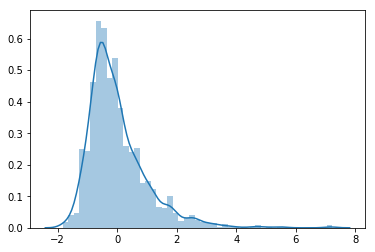

In [5]:
sns.distplot(saleprice_scaled)

# 2. Feature Engineering

**IMPORTANT** note: When you transform (change/delete/add columns) your train data you need to apply the same transformations to your test data. This is because your model will learn to make predictions with the transformed train data. It doesn't know how to handle untransformed data.

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

### Example feature generation: adding a feature representing the combined area of the building

In [7]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 3. Model building

In [8]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [9]:
train.shape

(1458, 221)

## Cross validation

In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import math

In [11]:
y_train_log = np.log1p(y_train)

def rmse_cv(model):
    return (np.sqrt(-cross_val_score(model, train.values, y_train_log, scoring="neg_mean_squared_error", cv = 5)))

In [12]:
model_rf = RandomForestRegressor()

In [13]:
score = rmse_cv(model_rf)
print("Random Forest score: {:.4f}".format(score.mean()))

Random Forest score: 0.1506


In [14]:
model_rf.fit(train,y_train_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
f_i = model_rf.feature_importances_

In [16]:
feature_importance = pd.DataFrame(data=f_i, index=train.columns)
feature_importance_top_15 = feature_importance.sort_values(by=0).nlargest(15,0)

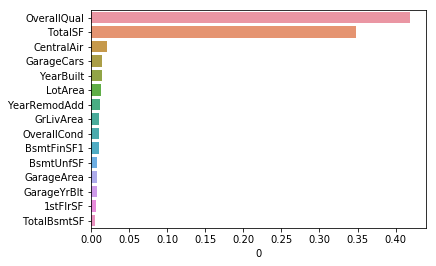

In [17]:
sns.barplot(y=feature_importance_top_15.index,x=feature_importance_top_15.loc[:, 0])

## Hyperparameter optimization

In [22]:
from sklearn.model_selection import GridSearchCV

# 4. Make a Submission

In [18]:
prediction = model_rf.predict(test)

In [19]:
prediction = np.exp(prediction)

In [20]:
prediction = pd.DataFrame(data=prediction, index=test_ID, columns=['SalePrice'])

In [21]:
prediction.head()

,SalePrice
Id,
1461,124851.132103
1462,162910.039973
1463,175766.174547
1464,184286.201235
1465,196425.018470


In [ ]:
prediction.to_csv('submissions/submission_starter_3.csv')